In [31]:
import os 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
import sklearn.decomposition
import umap.umap_
import umap.plot as umapp
import bokeh.plotting as bpl
import tensorflow 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [32]:
#### variables
Batch_size = 32
Validation_split = 0.2
Epochs= 300
WEIGHTS = 'imagenet'

In [33]:
##### Data Generator 
gen_args = dict(
        rescale=1./255
)

In [34]:
datagen = ImageDataGenerator(**gen_args)

In [35]:
##### variables
Batch_size = 128
model_name = r'C:\Users\arthu\Desktop\Classification\Models_inMT\RESNET_BestModel_RawData_in_withBrightness_20210422_19-38-22\RESNET_BestModel_RawData_in_withBrightness_20210422_19-38-22_model.hdf5'
path = 'models/'

In [36]:
from tensorflow.keras import backend as K 

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [37]:
dependencies = {
    'f1_m': f1_m}
model = tensorflow.keras.models.load_model(model_name, custom_objects = dependencies)

#model.summary()

In [38]:
model.compile(loss='categorical_crossentropy', optimizer= 'Adam', metrics=['accuracy', f1_m])

In [39]:
##### Model 
model = tensorflow.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50_input (InputLayer)  [(None, 48, 48, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                131136    
Total params: 23,718,848
Trainable params: 23,665,728
Non-trainable params: 53,120
_________________________________________________________________


In [40]:
test_generator = datagen.flow_from_directory(
        r'C:\Users\arthu\Desktop\Pipeline\SingleCell', 
        target_size=(48,48),
        color_mode="rgb",
        batch_size=Batch_size,
        class_mode='categorical',
        shuffle=False) 
x_test, y_test = next(test_generator)

Found 8604 images belonging to 1 classes.


In [41]:
predictions = model.predict(test_generator)
print(predictions.shape)

(8604, 64)


In [43]:
model_prediction = predictions.argmax(axis=-1)

In [44]:
def recursive_listdir(folder_path):
    file_list = []
    for root, dirs, files in os.walk(folder_path, topdown=False):
        for name in files:
                file_path = (os.path.join(root, name))
                file_list.append(file_path)
    
    return file_list

In [45]:
import re
img = recursive_listdir(r'C:\Users\arthu\Desktop\Pipeline\SingleCell')
labels=[]
for i in range(len(img)):
    result = re.search(r'\d+', img[i])
    i=i+1

In [46]:
i = 0
char = r'C:\Users\arthu\Desktop\Pipeline\SingleCell\1\2'
for im in img:
    if im.startswith(char):
        i = i + 1
print(i)

1096


In [47]:
class_prediction = [img, predictions]
f = pd.DataFrame(class_prediction)
d = f.transpose()
d.columns = ['img_name', 'Prediction']
d.head(5)

img_name  \
0  C:\Users\arthu\Desktop\Pipeline\SingleCell\1\2...   
1  C:\Users\arthu\Desktop\Pipeline\SingleCell\1\2...   
2  C:\Users\arthu\Desktop\Pipeline\SingleCell\1\2...   
3  C:\Users\arthu\Desktop\Pipeline\SingleCell\1\2...   
4  C:\Users\arthu\Desktop\Pipeline\SingleCell\1\2...   

                                          Prediction  
0  [0.0, 0.0, 0.2982866, 0.0, 0.0, 0.00802689, 0....  
1  [0.0, 0.0, 0.3641271, 0.0, 0.0, 0.0, 0.0, 0.69...  
2  [0.0, 0.0, 0.3893547, 0.0, 0.0, 0.0, 0.0, 0.78...  
3  [0.0, 0.0, 0.48126858, 0.0, 0.0, 0.0, 0.0, 0.9...  
4  [0.0, 0.0, 0.023621857, 0.0, 0.0, 0.3006249, 0...

In [48]:
predictions = predictions
print(predictions.shape)

(8604, 64)


---

# PCA & UMAP

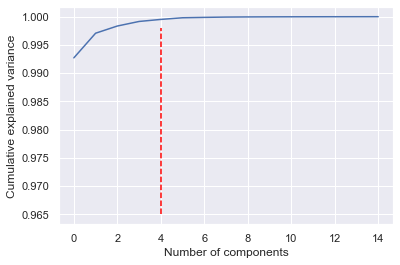

In [49]:
pca = sklearn.decomposition.PCA(n_components=15)
pca.fit(predictions)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.vlines(4, 0.965, 0.998, colors='red', linestyles='--', label="best model")

In [92]:
pca = sklearn.decomposition.PCA(n_components=10)
pca.fit(predictions)
x = pca.transform(predictions)

In [93]:
#sns.histplot(x)

In [94]:
#print(x)

In [95]:
explained_variance = pca.explained_variance_ratio_
print(explained_variance)

[9.9268711e-01 4.3600961e-03 1.2726815e-03 8.0717861e-04 3.6183174e-04
 2.9215045e-04 6.6938373e-05 5.5839584e-05 2.5284675e-05 1.4792775e-05]


In [96]:
columns = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
principalDf = pd.DataFrame(data = x
             , columns = columns)
print(principalDf)

             1         2         3         4         5         6         7  \
0    -7.425673 -1.274468 -0.240929  0.847741 -0.434707  0.461613  0.102000   
1    -7.425198 -0.900112 -0.544194  0.730612 -0.292341  0.186808  0.091891   
2    -7.425306 -0.827587 -0.590132  0.662563 -0.239025  0.142723  0.108111   
3    -7.424798 -0.364662 -0.874251  0.456318 -0.065008 -0.166095  0.086081   
4    -7.426821 -2.085429  0.846639  0.856933 -0.723903  0.824819 -0.093083   
...        ...       ...       ...       ...       ...       ...       ...   
8599 -7.428884 -2.437069  2.248754  0.032872 -0.561115  0.725791 -0.152294   
8600 -7.427633 -2.288094  1.445434  0.566720 -0.686866  0.826528 -0.111132   
8601 -7.436122 -3.091386  6.750388 -3.292879  0.426446 -0.313082 -0.217962   
8602 -7.425647 -1.093588 -0.417193  0.769219 -0.333472  0.316196  0.124021   
8603 -7.430603 -2.591431  3.277834 -0.705105 -0.368098  0.539294 -0.219037   

             8         9        10  
0     0.343893  0.099988 -

In [97]:
def umaper(random_state):
    mapper = umap.UMAP(random_state=random_state).fit(principalDf)
    #print(mapper)
    embedding = mapper.transform(principalDf)
    #print(embedding)
    assert(np.all(embedding == mapper.embedding_))
    #embedding.shape
    sns.set()
    #print("This is plot:", i)
    plt.figure(figsize=(15,10))
    plt.scatter(embedding[:, 0], embedding[:, 1], s=5)
    plt.gca().set_aspect('equal', 'datalim')
    plt.title('UMAP projection of the microglia reactivation states', fontsize=15)
    plt.colorbar(boundaries=np.arange(3)).set_ticks(np.arange(2))
    #plt.legend(labels=['Surveying label', 'Reactive label'], loc='best', fontsize=15)
    plt.show()
    plt.clf()
    #115

In [104]:
mapper = umap.UMAP().fit(principalDf)
#print(mapper)
embedding = mapper.transform(principalDf)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == mapper.embedding_))
embedding.shape
print(embedding)

[[11.635633  15.473031 ]
 [ 7.735225  11.067728 ]
 [ 7.0555944  9.611435 ]
 ...
 [-5.0044456 -5.416836 ]
 [ 8.423712  13.873063 ]
 [-5.4883227  1.3383266]]


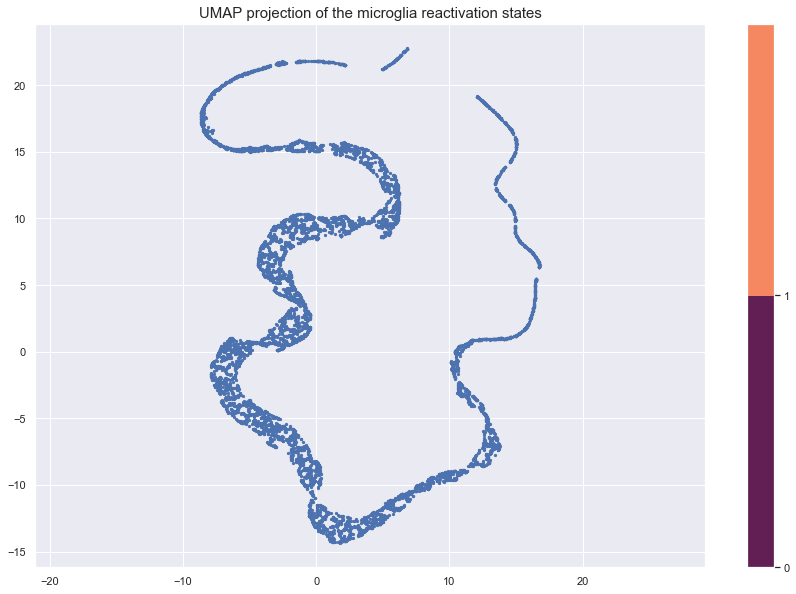

<Figure size 432x288 with 0 Axes>

In [105]:
#for i in range(0,201):
umaper(11)

---

C:\Users\arthu\anaconda3.2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\arthu\anaconda3.2\lib\site-packages\seaborn\distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


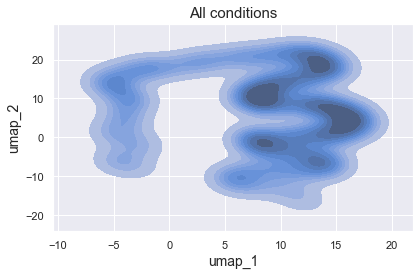

In [106]:
sns.set()
sns.kdeplot(embedding[:,0], embedding[:,1], shade=True, shade_lowest=False, cbar=False);
plt.xlabel('umap_1', fontsize=14)
plt.ylabel('umap_2', fontsize=14)
plt.title('All conditions', fontsize=15)
plt.tight_layout();